In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celloracle as co
import anndata as ad
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [6, 4.5]

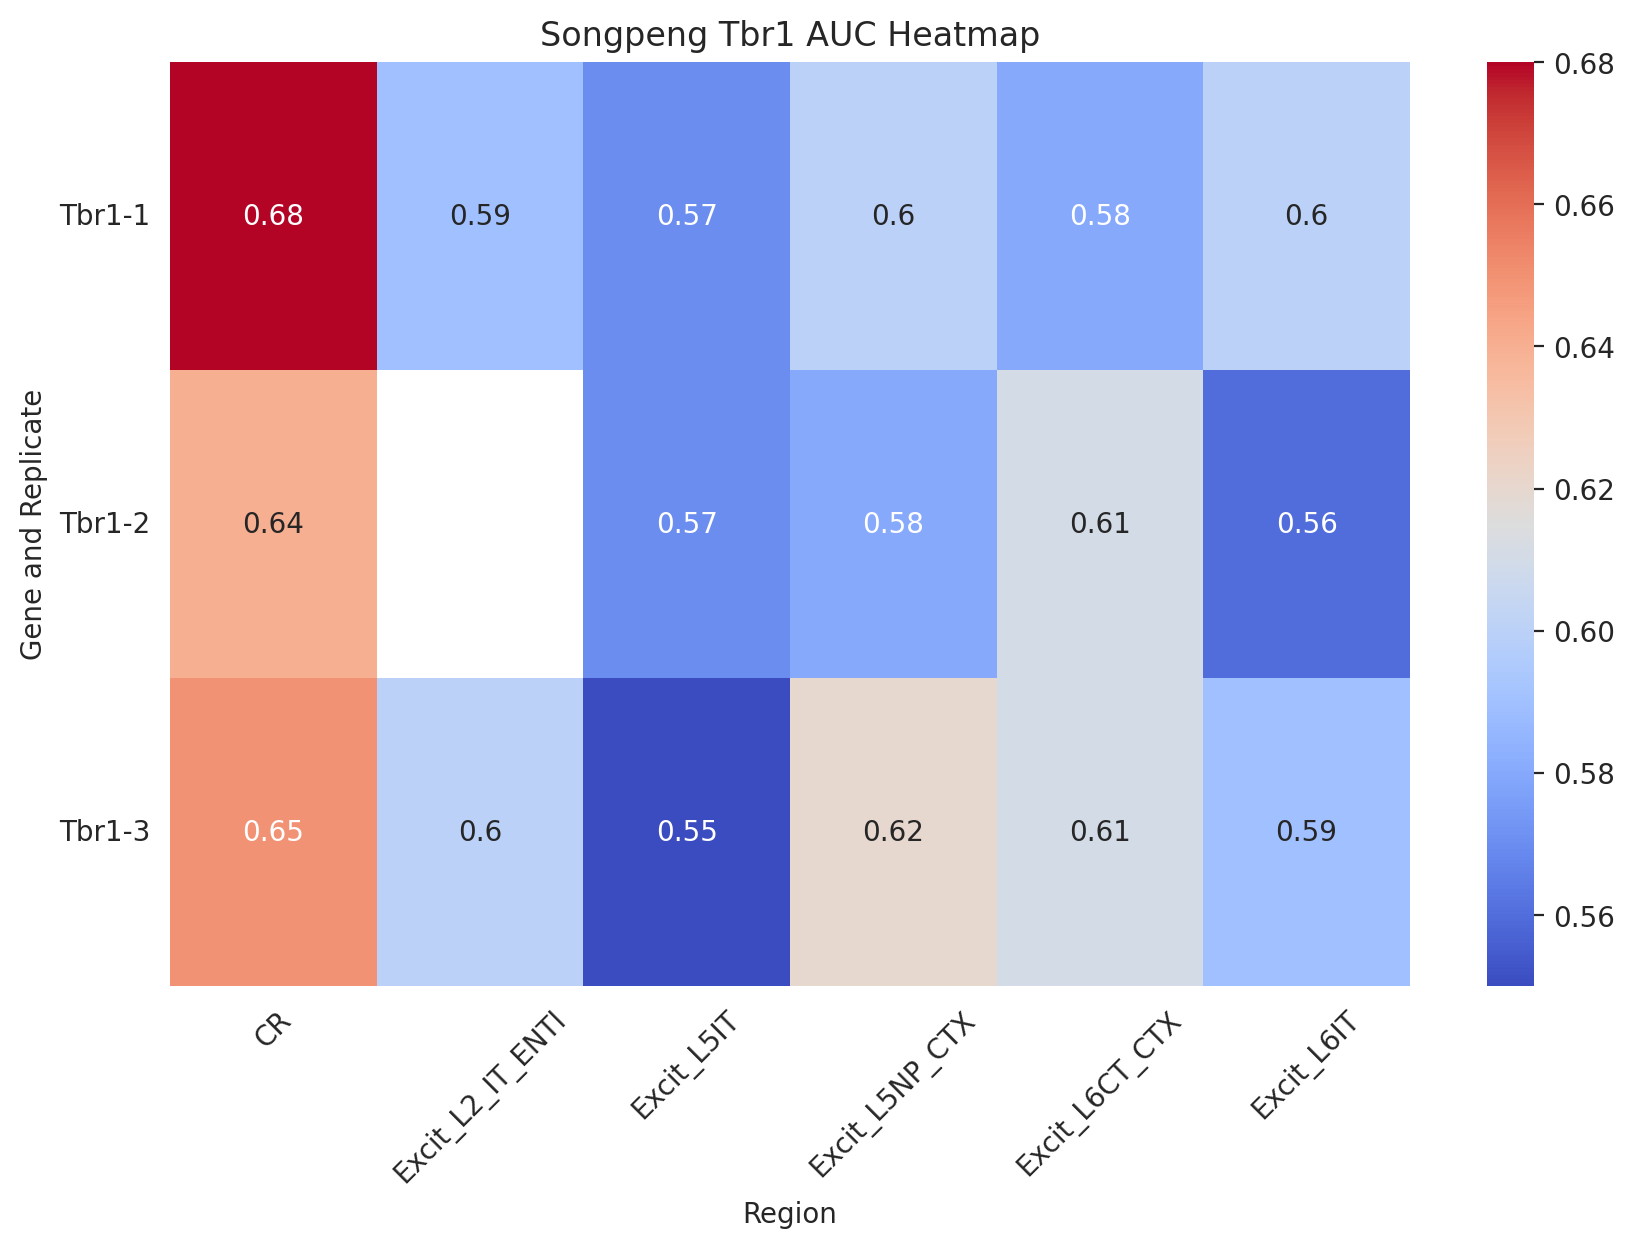

In [3]:
goi = "Tbr1"

# Read data from the text file
with open(f'jinlab/slurm-36348801.out', 'r') as file:
    data = file.readlines()  # Read all lines into a list
# Initialize an empty list to store the parsed values
parsed_data = []

# Loop through each line in the data
for line in data:
    if line.startswith("For"):
        if "SONGPENG" in line:
            # Split the line into parts
            parts = line.split(", SONGPENG AUC value of ")
            
            # Extract the gene, region, subset information
            gene_region_subset = parts[0].split(" ")[1]  # Get the gene_region_subset part
            auc = float(parts[1])  # Extract the AUC value
            
            # Further split gene_region_subset by '_'
            gene, region_subset = gene_region_subset.split('_', 1)
            
            # Split region_subset by the '.' delimiter
            region, subset = region_subset.split('.', 1)
        
            # Append the values to the list
            parsed_data.append([gene, region, subset, auc])

# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data, columns=["Gene", "Replicate", "Region", "AUC"])

# Pivot the DataFrame to get the maximum AUC for each gene, replicate, region, and subset
pivot_df = df.pivot_table(index=['Gene', 'Replicate'], 
                          columns='Region', 
                          values='AUC', 
                          aggfunc='max').reset_index()

pivot_df["Index"] = pivot_df["Gene"] + "-" + pivot_df["Replicate"]
pivot_df.set_index("Index", inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
"""
ax = sns.heatmap(heatmap_data.applymap(lambda x: 2 if x == 'blue' else (0 if x == 'red' else 1)), 
                 cmap='RdBu', 
                 cbar=False, 
                 linewidths=.5, 
                 linecolor='gray', 
                 annot=auc_data,  # Annotate heatmap with AUC values
                 fmt='.2f',  # Format AUC values to two decimal points
                 annot_kws={'size': 10, 'weight': 'bold'})  # Customize annotation size
"""

ax = sns.heatmap(pivot_df.iloc[:, 2:], annot=True, cmap='coolwarm', cbar=True)

# Customize the plot
plt.title(f'Songpeng {goi} AUC Heatmap')
plt.xlabel('Region')
plt.ylabel('Gene and Replicate')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

#plt.show()
plt.savefig(f"jinlab/graphs/heatmap/Songpeng_{goi}_AUC_Heatmap.pdf", format="pdf", bbox_inches='tight', dpi=300)

In [18]:
pivot_df.iloc[:, 2:]

Region,CR,Excit_L2_IT_ENTl,Excit_L5IT,Excit_L5NP_CTX,Excit_L6CT_CTX,Excit_L6IT
0,0.65,0.61,0.53,0.62,0.58,0.59
1,0.63,0.63,0.57,0.61,0.62,0.60
2,0.65,0.61,0.58,0.63,0.60,0.65


In [15]:
pivot_df

Region,Gene,Replicate,CR,Excit_L2_IT_ENTl,Excit_L5IT,Excit_L5NP_CTX,Excit_L6CT_CTX,Excit_L6IT
0,Tcf4,1,0.65,0.61,0.53,0.62,0.58,0.59
1,Tcf4,2,0.63,0.63,0.57,0.61,0.62,0.60
2,Tcf4,3,0.65,0.61,0.58,0.63,0.60,0.65


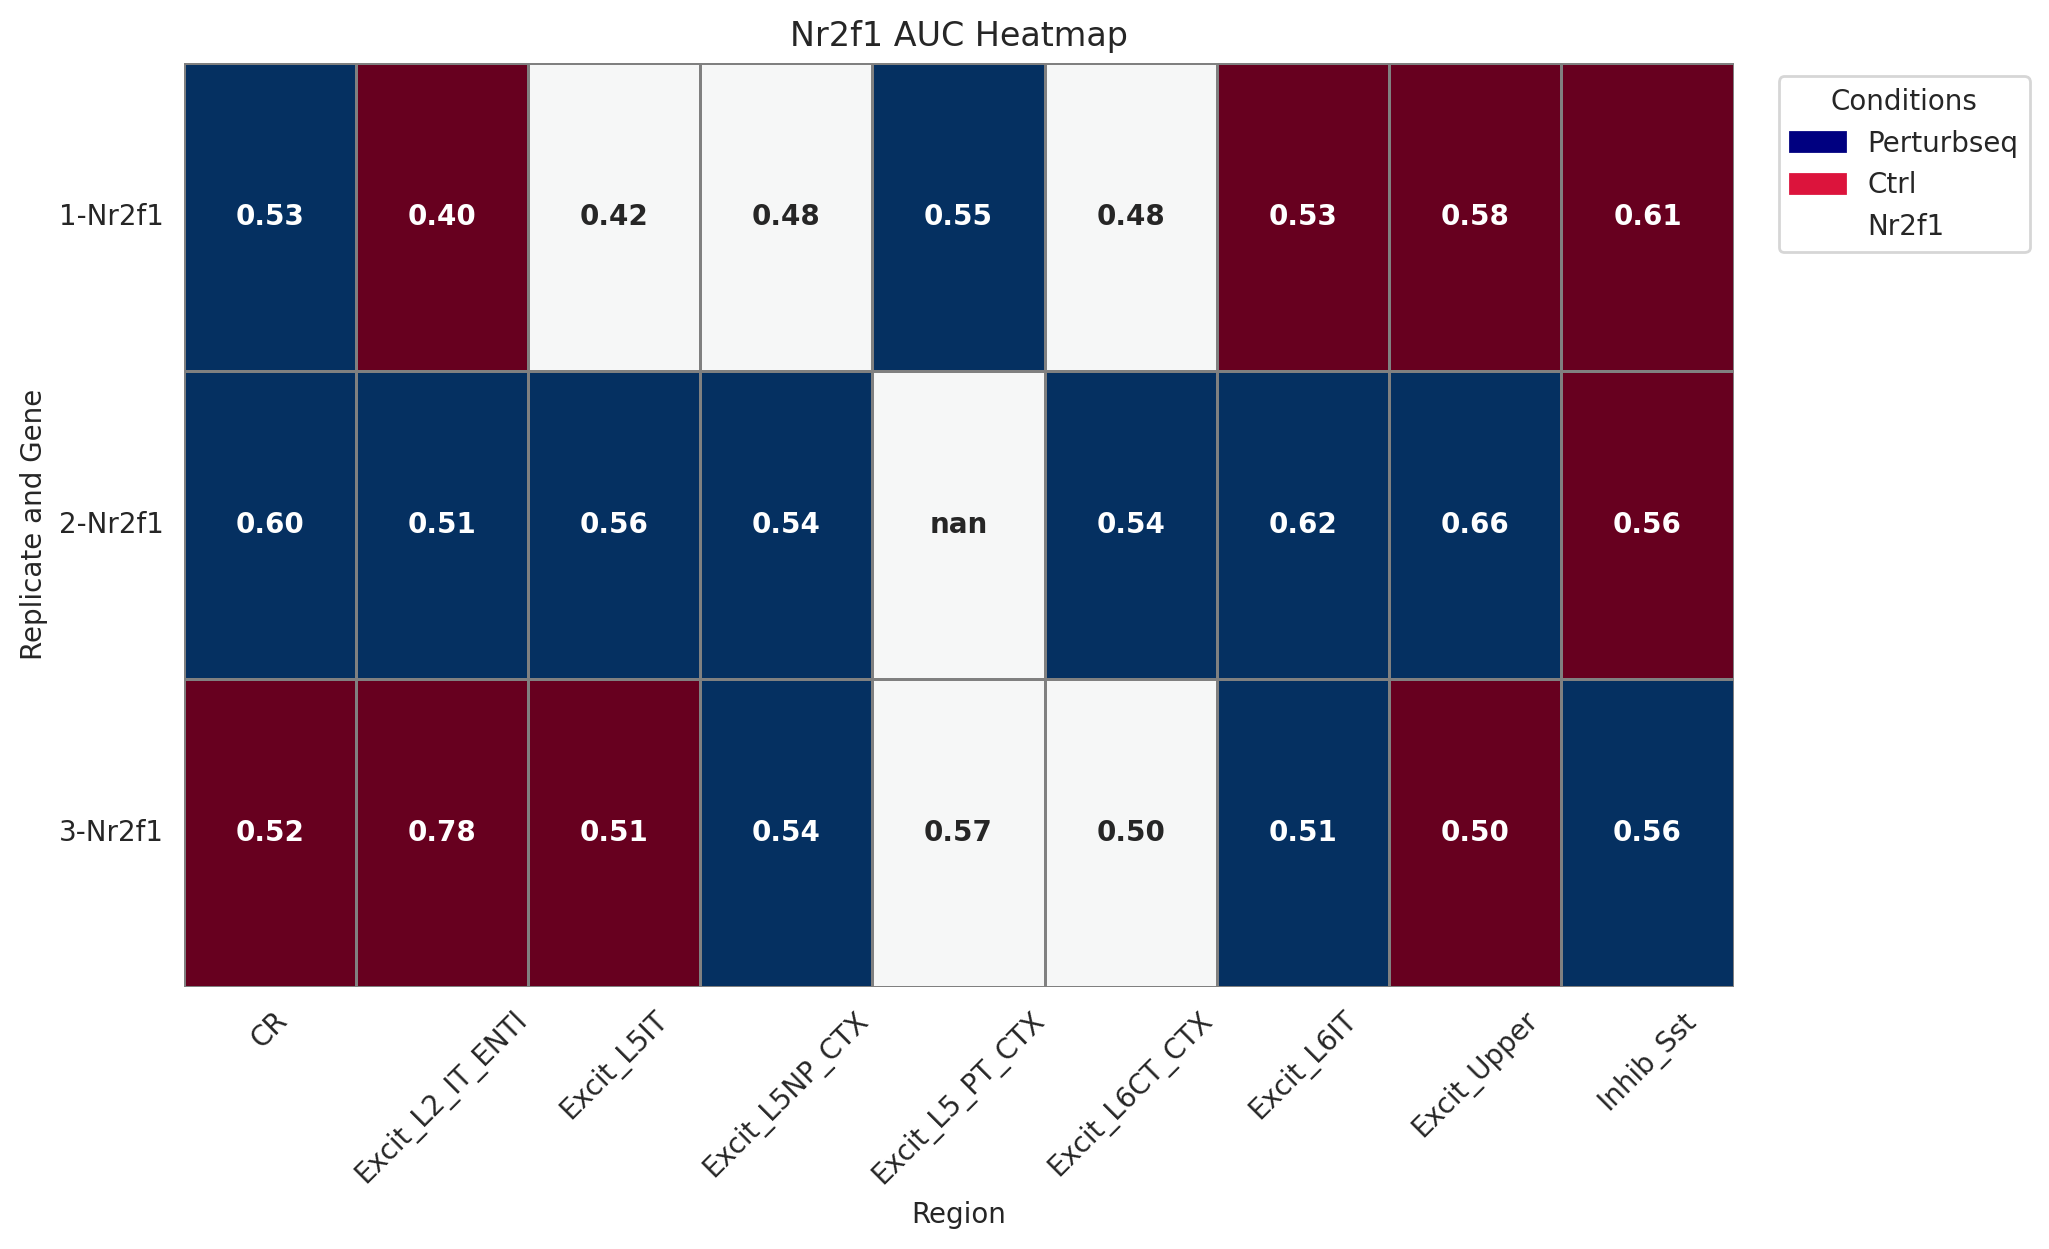

In [9]:
goi = "Nr2f1"

# Read data from the text file
with open(f'jinlab/{goi}_AUC.txt', 'r') as file:
    data = file.readlines()  # Read all lines into a list
# Initialize an empty list to store the parsed values
parsed_data = []

# Loop through each line in the data
for line in data:
    if line.startswith("For"):
        # Split the line into parts
        parts = line.split(", AUC value of ")
        
        # Extract the gene, region, subset information
        gene_region_subset = parts[0].split(" ")[1]  # Get the gene_region_subset part
        auc = float(parts[1])  # Extract the AUC value
        
        # Further split gene_region_subset by '_'
        gene, region_subset = gene_region_subset.split('_', 1)
        
        # Split region_subset by the '.' delimiter
        region, subset = region_subset.split('.', 1)

        brain, last = subset.split('.', 1)

        # Append the values to the list
        parsed_data.append([gene, region, brain, last, auc])

# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data, columns=["Gene", "Replicate", "Region", "Subset", "AUC"])

# Pivot the DataFrame to get the maximum AUC for each gene, replicate, region, and subset
pivot_df = df.pivot_table(index=['Gene', 'Replicate', 'Region'], 
                          columns='Subset', 
                          values='AUC', 
                          aggfunc='max').reset_index()

# Determine colors based on conditions
def assign_color(row):
    if row['peturbseq'] > row['ctrl']:
        return 'blue'
    elif row['ctrl'] > row['peturbseq']:
        return 'red'
    else:
        return 'black'

# Apply color assignment
pivot_df['Color'] = pivot_df.apply(assign_color, axis=1)
pivot_df['max'] = pivot_df[['peturbseq', 'ctrl', goi]].max(axis=1)


# Prepare the heatmap color data
heatmap_data = pivot_df.pivot_table(index=['Replicate', 'Gene'], 
                                    columns='Region', 
                                    values='Color', 
                                    aggfunc='first')

# Prepare the heatmap AUC data for annotation
auc_data = pivot_df.pivot_table(index=['Replicate', 'Gene'], 
                                columns='Region', 
                                values='max',  # Use peturbseq as the representative AUC values
                                aggfunc='first')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data.applymap(lambda x: 2 if x == 'blue' else (0 if x == 'red' else 1)), 
                 cmap='RdBu', 
                 cbar=False, 
                 linewidths=.5, 
                 linecolor='gray', 
                 annot=auc_data,  # Annotate heatmap with AUC values
                 fmt='.2f',  # Format AUC values to two decimal points
                 annot_kws={'size': 10, 'weight': 'bold'})  # Customize annotation size

# Customize the plot
plt.title(f'{goi} AUC Heatmap')
plt.xlabel('Region')
plt.ylabel('Replicate and Gene')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Create a legend
blue_patch = mpatches.Patch(color='navy', label='Perturbseq')
red_patch = mpatches.Patch(color='crimson', label='Ctrl')
black_patch = mpatches.Patch(color='white', label=goi)

# Add the legend to the plot
plt.legend(handles=[blue_patch, red_patch, black_patch], 
           title="Conditions", 
           loc='upper right', 
           bbox_to_anchor=(1.2, 1))  # Adjust position as needed


plt.show()
#plt.savefig(f"jinlab/graphs/{goi}_AUC_Heatmap.jpg", bbox_inches='tight')

# VARIABLE GENES


In [10]:
perturb_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Foxg1_1.CR.peturbseq.calculated.subclass.celloracle.oracle")


In [16]:
if goi in perturb_oracle.adata.var_names:
    print("true")
else:
    print("false")

false


In [9]:
goi = "Foxg1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
perturb_oracle.simulate_shift(perturb_condition={goi: 0.0},
                      GRN_unit="cluster",
                      n_propagation=2)


In [12]:
# Get Sean's DEG list
df = pd.read_csv(f"/gpfs/home/asun/jinlab/tsv/edgeR_LRT_with_sva.Foxg1_1.CR.tsv", sep='\t')
df_sorted = df.iloc[df['logFC'].abs().argsort()]
df_sorted.set_index("Unnamed: 0")
rows_to_add = df_sorted.loc[df_sorted["Unnamed: 0"] == goi]
DEG = df_sorted.tail(3000)
DEG = pd.concat([DEG, rows_to_add], ignore_index=True)
DEG.rename(columns={'Unnamed: 0': 'Gene'}, inplace=True)

In [14]:
df_sorted[

,Unnamed: 0,logFC,logCPM,LR,PValue,padj


In [3]:
perturb_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Tbr1_1.Excit_L6CT_CTX.peturbseq.calculated.subclass.celloracle.oracle")
ctrl_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Tbr1_1.Excit_L6CT_CTX.ctrl.calculated.subclass.celloracle.oracle")

In [5]:
goi = "Tbr1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
perturb_oracle.simulate_shift(perturb_condition={goi: 0.0},
                      GRN_unit="cluster",
                      n_propagation=2)

# Enter perturbation conditions to simulate signal propagation after the perturbation.
ctrl_oracle.simulate_shift(perturb_condition={goi: 0.0},
                           GRN_unit="cluster",
                           n_propagation=2)

In [7]:
cluster_1_cells = perturb_oracle.adata[perturb_oracle.adata.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2_cells = ctrl_oracle.adata[ctrl_oracle.adata.obs['predicted.subclass'] == 'L6 CT CTX']


In [8]:
deltaX_1 = cluster_1_cells.layers["delta_X"]
deltaX_2 = cluster_2_cells.layers["delta_X"]
mean_expression_cluster_1 = deltaX_1.mean(axis=0)
mean_expression_cluster_2 = deltaX_2.mean(axis=0)

In [9]:
mean_expression_cluster_1

array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -1.21831333])

In [11]:
genes = perturb_oracle.adata.var_names
perturbation_1 = pd.DataFrame({
    'Gene': genes,
    'Mean Expression': mean_expression_cluster_1,
})
perturbation_2 = pd.DataFrame({
    'Gene': genes,
    'Mean Expression': mean_expression_cluster_2,
})

In [26]:
# Step 2: Sort by mean expression
perturbation_1_sorted = perturbation_1.iloc[perturbation_1['Mean Expression'].abs().argsort()[::-1]]
perturbation_2_sorted = perturbation_2.iloc[perturbation_2['Mean Expression'].abs().argsort()[::-1]]

#perturbation_2_sorted = perturbation_2.sort_values(by='Mean Expression', ascending=False)

# Step 3: Keep only the top 10 genes
perturbation_1_top10 = perturbation_1_sorted.head(15)
perturbation_2_top10 = perturbation_2_sorted.head(15)

In [34]:
genes_perturbation_1 = set(perturbation_1_top10['Gene'])
genes_perturbation_2 = set(perturbation_2_top10['Gene'])

# Find genes that are in perturbation_1 but not in perturbation_2
genes_only_in_perturbation_1 = genes_perturbation_1 - genes_perturbation_2

# Find genes that are in perturbation_2 but not in perturbation_1
genes_only_in_perturbation_2 = genes_perturbation_2 - genes_perturbation_1

# Print results
print("Genes only in perturbation_1:")
print(genes_only_in_perturbation_1)

print("\nGenes only in perturbation_2:")
print(genes_only_in_perturbation_2)

Genes only in perturbation_1:
{'Ppfibp1', 'Acp6', 'Ppp2r1b', 'Rab26', 'Sema6d', 'Jup'}

Genes only in perturbation_2:
{'Pgm1', 'Ift46', 'Acy1', 'Eif4ebp1', 'Stat2', 'Lin28b'}


In [15]:
count = 0
for index, row in perturbation_2.iterrows():
    gene = row['Gene']
    change = row['Mean Expression']
    # Skip if the gene is the central node or if the expression change is zero
    if change != 0:
        count += 1
count

197

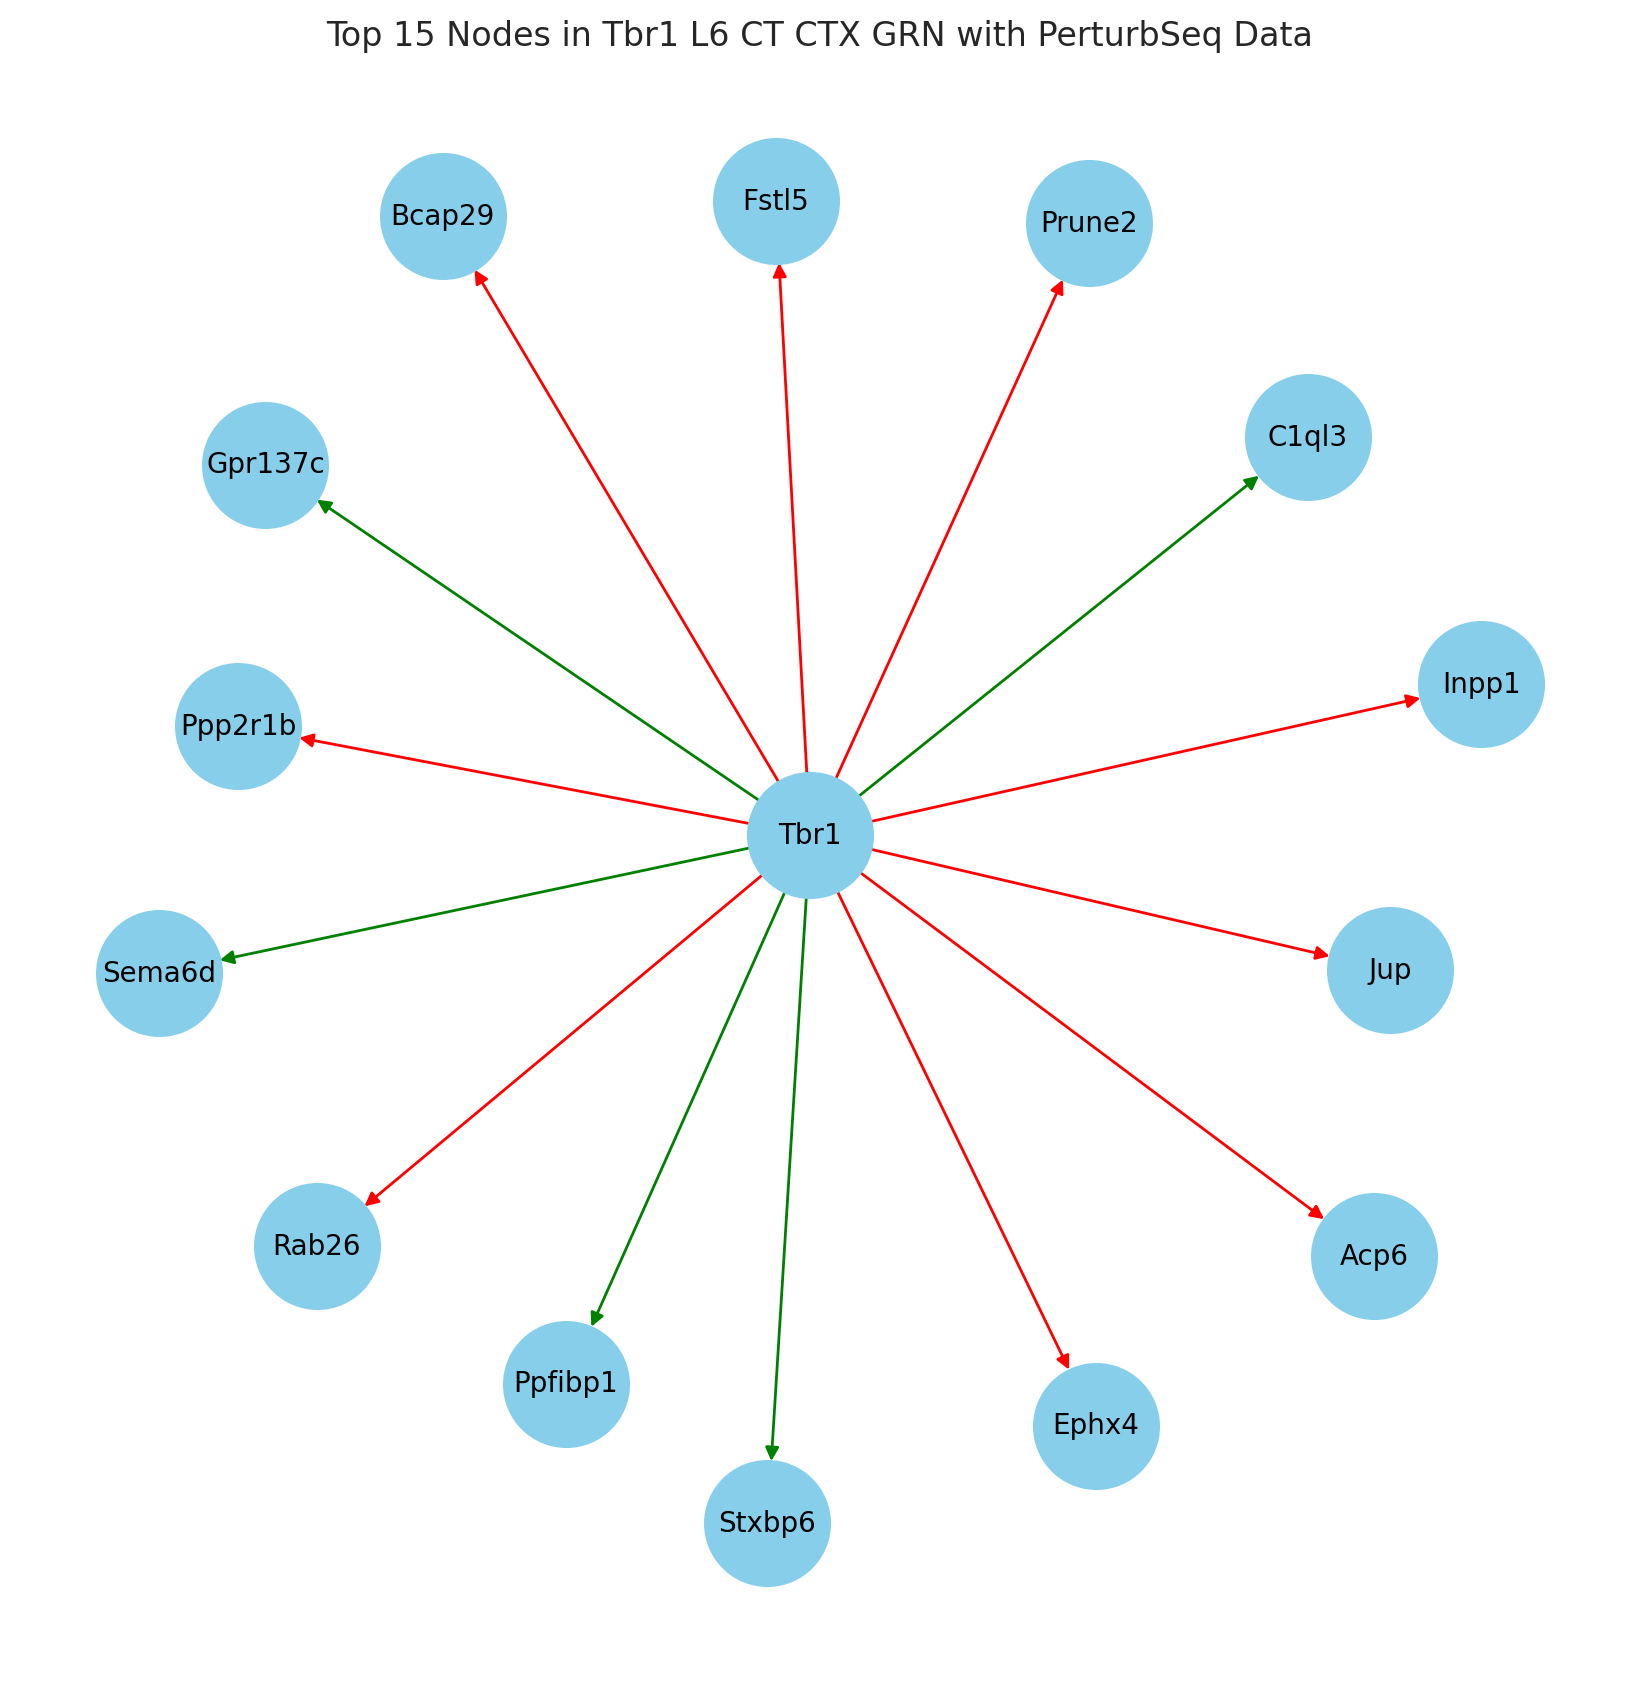

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

gene_expression_changes_df = perturbation_1_top10

# Initialize a directed graph
G = nx.DiGraph()

# Central node is Tbr1
central_node = 'Tbr1'

# Add the central node (Tbr1)
G.add_node(central_node)

# Loop through the DataFrame and add edges for genes with non-zero expression changes
for index, row in gene_expression_changes_df.iterrows():
    gene = row['Gene']
    change = row['Mean Expression']
    
    # Skip if the gene is the central node or if the expression change is zero
    if gene != central_node and change != 0:
        G.add_node(gene)
        # Add an edge from Tbr1 to this gene
        G.add_edge(central_node, gene, color='green' if change > 0 else 'red')

# Get edge colors based on the expression change (green for positive, red for negative)
edge_colors = [G[u][v]['color'] for u, v in G.edges]

# Position nodes in a layout
pos = nx.spring_layout(G)

# Plot the network with node labels and colored edges
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, edge_color=edge_colors, arrows=True)
plt.title('Top 15 Nodes in Tbr1 L6 CT CTX GRN with PerturbSeq Data')
plt.tight_layout()
plt.show()
#plt.savefig("jinlab/nxtbr1ctrl.jpg")  # Ensure to call show() to display the plot


In [10]:
peturb = oracle.adata.copy()
control = ['NonTarget1', 'NonTarget2', 'SafeTarget', 'GFP']
peturb_ctrl = peturb[peturb.obs['assignDS'].isin(control)].copy()
tbr1 = ['Tbr1_1', 'Tbr1_2', 'Tbr1_3']
peturb_tbr1 = peturb[peturb.obs['assignDS'].isin(tbr1)].copy()
foxg1 = ['Foxg1_1', 'Foxg1_2', 'Foxg1_3']
peturb_foxg1 = peturb[peturb.obs['assignDS'].isin(foxg1)].copy()
nr2f1 = ['Nr2f1_1', 'Nr2f1_2', 'Nr2f1_3']
peturb_nr2f1 = peturb[peturb.obs['assignDS'].isin(nr2f1)].copy()

In [ ]:
cluster_1_cells = peturb_foxg1
cluster_2_cells = peturb_ctrl

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0).A1
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0).A1

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names

In [ ]:
links = co.load_hdf5("jinlab/links.ctrl_amended.subclasses.celloracle.links")

In [4]:
test_adata = oracle.adata


In [7]:
test_adata.X = test_adata.layers["delta_X"]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_gene_network(adata):
    # Assuming deltaX is stored in adata.X
    deltaX = adata.X
    
    # Create a graph
    G = nx.DiGraph()  # Directed graph for gene regulatory network
    
    genes = adata.var_names  # Assuming genes are in var_names
    
    # Add nodes (genes)
    for gene in genes:
        G.add_node(gene)
    
    # Add edges with weights (deltaX) and assign colors based on sign
    edges = []
    edge_colors = []
    
    for i, gene1 in enumerate(genes):
        for j, gene2 in enumerate(genes):
            if i != j:  # Skip self-interactions
                delta_value = deltaX[i, j]
                if delta_value != 0:  # Only include interactions with non-zero deltaX
                    G.add_edge(gene1, gene2, weight=delta_value)
                    edges.append((gene1, gene2))
                    if delta_value > 0:
                        edge_colors.append('green')
                    else:
                        edge_colors.append('red')
    
    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for positioning the nodes
    plt.figure(figsize=(12, 12))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=2, alpha=0.6)
    
    plt.title('Gene Regulatory Network')
    plt.show()

# Assuming `adata` is the input AnnData object
visualize_gene_network(test_adata)



KeyboardInterrupt



# DEG

In [3]:
goi = "Tbr1"

songpeng_oracle = co.load_hdf5("jinlab/songpeng_grn/songpeng.L6_CT_CTX_Glut.calculated.subclass.celloracle.oracle")

# Enter perturbation conditions to simulate signal propagation after the perturbation.
songpeng_oracle.simulate_shift(perturb_condition={goi: 0},
                      GRN_unit="cluster",
                      n_propagation=3)

oracle_input = songpeng_oracle.adata.copy()
oracle_count = songpeng_oracle.adata.copy()
oracle_input.X = songpeng_oracle.adata.layers["simulation_input"].copy()
oracle_count.X = songpeng_oracle.adata.layers["simulated_count"].copy()

# Assuming 'adata' is your AnnData object and clusters are identified
# 'cluster_key' is the key in adata.obs that contains cluster labels
# 'cluster_1' and 'cluster_2' are the cluster labels you want to compare

cluster_1_cells = oracle_count
cluster_2_cells = oracle_input

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names
fold_change_df1 = pd.DataFrame({
    'Gene': genes,
    'Treatment_Fold_Change': fold_change,
    'Treatment_Log2_Fold_Change': log_fold_change
})

# Sort by fold change or log fold change
fold_change_df1 = fold_change_df1.sort_values(by='Treatment_Fold_Change', ascending=False)

df = pd.read_csv('jinlab/tsv/edgeR_LRT_with_sva.Tbr1_1.Excit_L6CT_CTX.tsv', sep='\t')
df = df.sort_values(by='logFC', ascending=False)
df_sorted = df.iloc[df['logFC'].abs().argsort()]
df_sorted.rename(columns={"Unnamed: 0": "Gene"}, inplace=True)
merged_df = fold_change_df1.merge(df_sorted, how='left', left_on='Gene', right_on='Gene')
merged_df.dropna()

,Gene,Treatment_Fold_Change,Treatment_Log2_Fold_Change,logFC,logCPM,LR,PValue,padj
0,Ptchd4,2.106573,1.074898,-0.387421,5.319731,0.060679,0.805426,0.965864
1,Ifitm2,2.103409,1.072729,0.263096,5.696853,0.040155,0.841178,0.977243
4,Gm49678,1.612650,0.689433,0.035435,6.097033,0.000979,0.975037,0.998244
5,Cntn6,1.407233,0.492862,0.185639,6.466119,0.065352,0.798229,0.963827
6,Luzp1,1.343697,0.426208,0.278666,6.219040,0.083499,0.772610,0.957675
...,...,...,...,...,...,...,...,...
3276,Eepd1,0.357936,-1.482226,-5.882671,4.392392,3.472839,0.062384,0.466691
3277,Srgap1,0.334414,-1.580294,-0.455692,7.118306,0.805565,0.369435,0.778440
3278,Nkain3,0.200094,-2.321253,0.373714,6.355667,0.220592,0.638589,0.913670
3279,Hey1,0.106593,-3.229813,4.955086,4.970285,7.459004,0.006312,0.257241


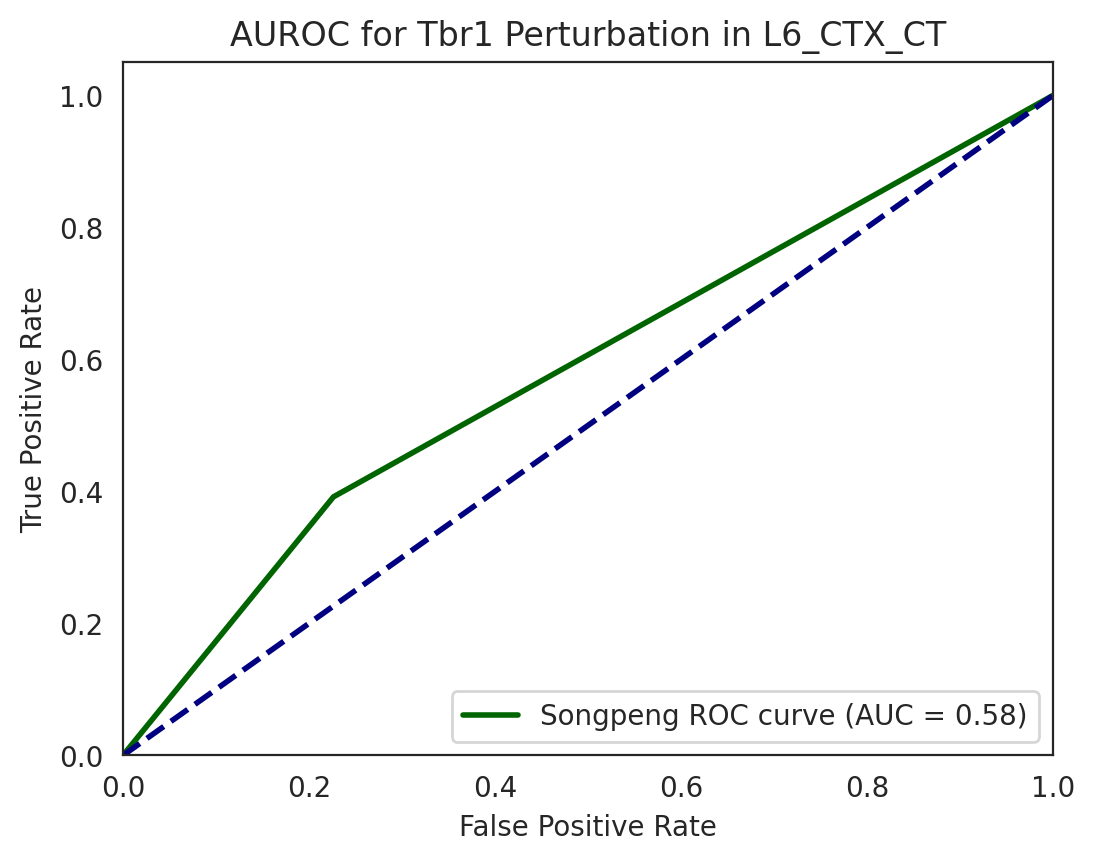

In [4]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score

# Example arrays (logFC for in silico and functional perturbations)
# Positive logFC classified as 1, negative as 0
#ctrl_fc = result['Control_Log2_Fold_Change']  # LogFC from in silico perturbations
perturb_fc = merged_df['Treatment_Log2_Fold_Change']
functional_fc = merged_df['logFC']  # LogFC from functional perturbations

#ctrl_class = [1 if fc > 0 else 0 for fc in ctrl_fc]
perturb_class = [1 if fc > 0 else 0 for fc in perturb_fc]
functional_class = [1 if fc > 0 else 0 for fc in functional_fc]

# Create confusion matrix
#ctrl_tn, ctrl_fp, ctrl_fn, ctrl_tp = confusion_matrix(functional_class, ctrl_class).ravel()
perturb_tn, perturb_fp, perturb_fn, perturb_tp = confusion_matrix(functional_class, perturb_class).ravel()
#print(f"Confusion Matrix: TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")

# Calculate the ROC curve
#ctrl_fpr, ctrl_tpr, ctrl_thresholds = roc_curve(ctrl_class, functional_class)
perturb_fpr, perturb_tpr, perturb_thresholds = roc_curve(perturb_class, functional_class)


# Calculate the AUC
#ctrl_roc_auc = auc(ctrl_fpr, ctrl_tpr)
perturb_roc_auc = auc(perturb_fpr, perturb_tpr)

#print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
#plt.plot(ctrl_fpr, ctrl_tpr, color='darkorange', lw=2, label=f'Control ROC curve (AUC = {ctrl_roc_auc:.2f})')
plt.plot(perturb_fpr, perturb_tpr, color='darkgreen', lw=2, label=f'Songpeng ROC curve (AUC = {perturb_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for Tbr1 Perturbation in L6_CTX_CT')
plt.legend(loc="lower right")
#plt.savefig("jinlab/songpeng_auroc.jpg")

In [8]:
perturb_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Tbr1_1.Excit_L6CT_CTX.peturbseq.calculated.subclass.celloracle.oracle")
ctrl_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Tbr1_1.Excit_L6CT_CTX.ctrl.calculated.subclass.celloracle.oracle")
goi_oracle = co.load_hdf5("jinlab/deg_grn/ctxobj.Tbr1_1.Excit_L6CT_CTX.Tbr1.calculated.subclass.celloracle.oracle")

In [42]:
# Step 1: Create a new layer for Fold Change
fold_change_layer = perturb_oracle.adata.layers["simulated_count"] / (perturb_oracle.adata.layers["simulation_input"] + 1e-6)  # Adding a pseudocount to avoid division by zero
perturb_oracle.adata.layers["fold_change"] = fold_change_layer
# Step 2: Create a new layer for Log2 Fold Change
log_fold_change_layer = np.log2(fold_change_layer + 1e-6)  # Adding a pseudocount to avoid log(0)
perturb_oracle.adata.layers["log_fold_change"] = log_fold_change_layer

In [36]:
perturb_oracle.adata.layers["log_fold_change"]

array([[-5.84964110e-06, -3.73003175e-06, -1.07750282e-05, ...,
        -8.95663640e-05, -4.47123653e-05,  5.88789840e-01],
       [-2.36600704e-06, -3.28165106e-06, -9.12202378e-06, ...,
        -3.76274293e-04, -4.39076448e-05, -3.87518126e-01],
       [-1.03635855e-05, -4.42194798e-06, -1.24844900e-05, ...,
        -8.37025722e-05, -1.06798047e-04,  7.31384494e-01],
       ...,
       [-5.22723522e-06, -3.81691826e-06, -1.20072397e-05, ...,
        -1.14907446e-04, -3.93357084e-05, -3.96146713e-01],
       [-1.28594265e-05, -5.06414044e-06, -1.01467196e-05, ...,
        -6.36683247e-05, -1.09087085e-04,  6.35472919e-01],
       [-6.84797561e-06, -1.08302309e-03, -1.10523192e-05, ...,
        -1.56851141e-04, -7.07740254e-05, -6.71359690e-01]])

In [43]:
test_oracle = perturb_oracle.adata.copy()
test_oracle.X = test_oracle.layers["log_fold_change"]
test_oracle.to_df()

,Micall1,Usf2,1500015A07Rik,C130026L21Rik,Slc20a2,Ajap1,Pigo,Flrt1,Numb,Prtn3,...,Gpx3,Sdr42e1,Zfp526,Dock5,Samd11,Slc22a21,Htr5a,Fam53b,Lrrc56,Tbr1
Ch1_AAACCTGTCAGGTTCA-1,-0.000006,-0.000004,-0.000011,-0.000009,-0.000010,-1.467293e-06,-0.000014,-0.000020,-0.000004,-0.000011,...,-0.000046,-0.000026,-0.000071,-0.000068,-0.000043,-0.000037,-0.000039,-0.000090,-0.000045,-0.588792
Ch1_AAACCTGTCCTTTACA-1,-0.000009,-0.000005,-0.000009,-0.000010,-0.000011,3.217841e-07,-0.000023,-0.000017,-0.000006,-0.000009,...,-0.000037,-0.000051,-0.000038,-0.000034,-0.000026,-0.000022,-0.000024,-0.000376,-0.000044,0.387514
Ch1_AAACGGGCACAGGAGT-1,-0.000010,-0.000004,-0.000012,-19.931569,-0.000746,-9.387514e-04,-0.000019,-0.000021,0.004797,-0.000011,...,0.001703,-0.000052,-0.000048,-19.931569,-0.000441,-0.000232,-0.000521,-0.000084,-0.000107,-0.731386
Ch1_AAACGGGCATGCAATC-1,-0.000006,-0.000004,-0.000010,-0.000017,-0.000010,-5.027764e-06,-0.000015,-0.000016,-0.000006,-0.000007,...,-0.000024,-0.000041,-0.000055,-0.000052,-0.000047,-0.000050,-0.000029,-0.000168,-0.000055,-0.193830
Ch1_AAACGGGGTAATAGCA-1,-0.000010,-0.000004,-0.000011,-0.000007,-0.000009,-3.505261e-07,-0.000011,-0.000015,-0.000004,-0.000009,...,-0.000035,-0.000031,-0.000058,-0.000038,-0.000023,-0.000033,-0.000024,-0.000083,-0.000045,-0.179377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ch5_TTTGGTTGTTCACGGC-1,-0.000010,-0.002575,-0.000009,-0.000038,-0.015536,2.117735e-02,-0.000024,0.003270,-0.002102,-0.000011,...,-0.000030,-0.000040,-0.000030,-0.000042,-0.000082,-0.000042,-0.000033,-0.000023,-0.000090,-1.564668
Ch5_TTTGGTTTCGAACGGA-1,-0.000012,-0.002387,-0.000008,-0.000040,-0.004528,2.658612e-02,-0.000021,0.003493,-0.001595,-0.000011,...,-0.000036,-0.000111,-0.000028,-0.000333,-0.000074,-0.000050,-0.000030,-0.000079,-0.000050,-1.332239
Ch5_TTTGGTTTCTTTACGT-1,-0.000005,-0.000004,-0.000012,-0.000013,-0.000050,-5.118770e-05,-0.000012,-0.000032,-0.000041,-0.000007,...,-0.000023,-0.000058,-0.000035,-0.000016,-0.000025,-0.000041,-0.000019,-0.000115,-0.000039,0.396142
Ch5_TTTGTCAGTTGACGTT-1,-0.000013,-0.000005,-0.000010,-19.931569,-0.000650,-9.449520e-04,-0.000022,-0.000031,0.005040,-0.000011,...,0.001138,-0.000083,-0.000052,-19.931569,-0.000441,-0.000142,-19.931569,-0.000064,-0.000109,-0.635475


In [56]:
test_oracle_df = test_oracle.to_df()

max_rows = 20
max_cols = 20

#log_fold_change_df_restricted = test_oracle_df.iloc[:min(max_rows, test_oracle_df.shape[0]), :][gene_list]

log_fold_change_df_restricted = test_oracle_df.iloc[:min(max_rows, test_oracle_df.shape[0]), :min(max_cols, test_oracle_df.shape[1])]


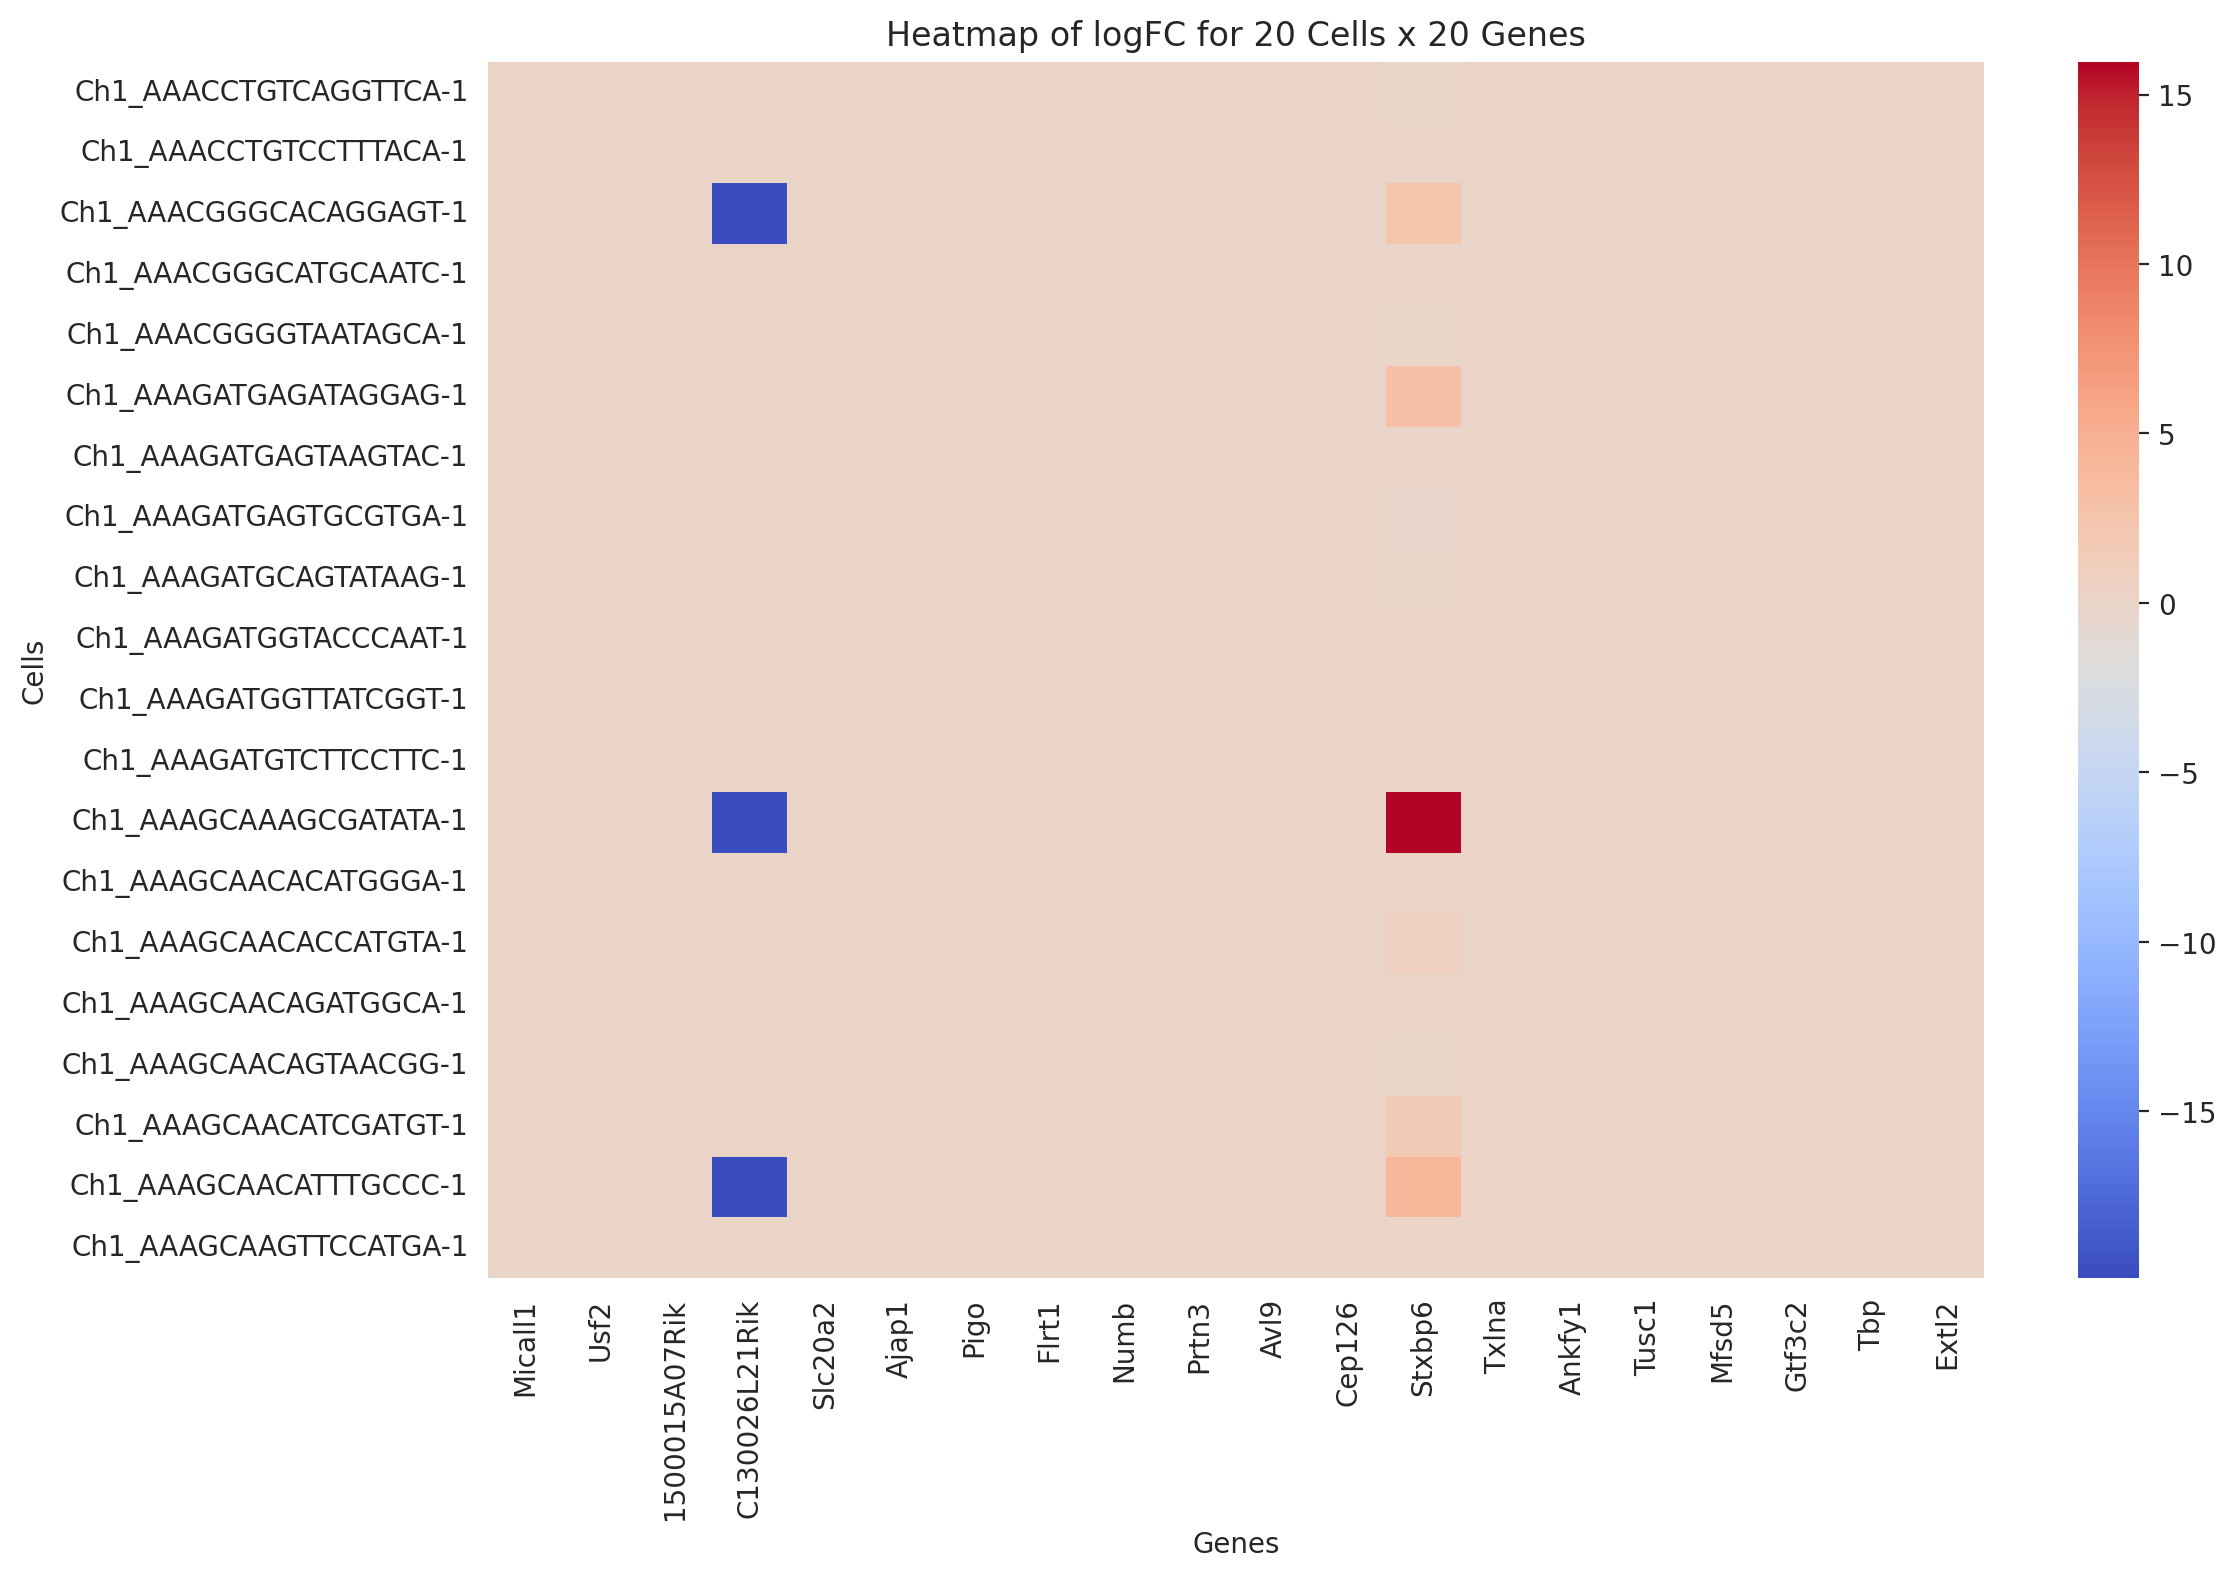

In [60]:
# Step 3: Create heatmaps
plt.figure(figsize=(12, 8))

sns.heatmap(log_fold_change_df_restricted, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)
plt.title('Heatmap of logFC for 20 Cells x 20 Genes')
plt.xlabel('Genes')
plt.ylabel('Cells')
# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.savefig("jinlab/heatmap.jpg")

In [9]:
goi = "Tbr1"

# Enter perturbation conditions to simulate signal propagation after the perturbation.
perturb_oracle.simulate_shift(perturb_condition={goi: 0.46},
                      GRN_unit="cluster",
                      n_propagation=3)

ctrl_oracle.simulate_shift(perturb_condition={goi: 0.46},
                      GRN_unit="cluster",
                      n_propagation=3)

goi_oracle.simulate_shift(perturb_condition={goi: 0.46},
                      GRN_unit="cluster",
                      n_propagation=3)

perturb_oracle_input = perturb_oracle.adata.copy()
perturb_oracle_count = perturb_oracle.adata.copy()
perturb_oracle_input.X = perturb_oracle.adata.layers["simulation_input"].copy()
perturb_oracle_count.X = perturb_oracle.adata.layers["simulated_count"].copy()

cluster_1_cells = perturb_oracle_count[perturb_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2_cells = perturb_oracle_input[perturb_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names
perturb_oracle_fc_df = pd.DataFrame({
    'Gene': genes,
    'PerturbSeq_Fold_Change': fold_change,
    'PerturbSeq_Log2_Fold_Change': log_fold_change
})

# Sort by fold change or log fold change
perturb_oracle_fc_df = perturb_oracle_fc_df.sort_values(by='PerturbSeq_Fold_Change', ascending=False)

ctrl_oracle_input = ctrl_oracle.adata.copy()
ctrl_oracle_count = ctrl_oracle.adata.copy()
ctrl_oracle_input.X = ctrl_oracle.adata.layers["simulation_input"].copy()
ctrl_oracle_count.X = ctrl_oracle.adata.layers["simulated_count"].copy()

cluster_1_cells = ctrl_oracle_count[ctrl_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2_cells = ctrl_oracle_input[ctrl_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names
ctrl_oracle_fc_df = pd.DataFrame({
    'Gene': genes,
    'Control_Fold_Change': fold_change,
    'Control_Log2_Fold_Change': log_fold_change
})

# Sort by fold change or log fold change
ctrl_oracle_fc_df = ctrl_oracle_fc_df.sort_values(by='Control_Fold_Change', ascending=False)

goi_oracle_input = goi_oracle.adata.copy()
goi_oracle_count = goi_oracle.adata.copy()
goi_oracle_input.X = goi_oracle.adata.layers["simulation_input"].copy()
goi_oracle_count.X = goi_oracle.adata.layers["simulated_count"].copy()

cluster_1_cells = goi_oracle_count[goi_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2_cells = goi_oracle_input[goi_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']

# Calculate mean expression for each gene in both clusters
mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)

pseudocount = 1e-6 
fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
log_fold_change = np.log2((mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount))

# Convert to a DataFrame for easy viewing
genes = cluster_1_cells.var_names
goi_oracle_fc_df = pd.DataFrame({
    'Gene': genes,
    'Goi_Fold_Change': fold_change,
    'Goi_Log2_Fold_Change': log_fold_change
})

# Sort by fold change or log fold change
goi_oracle_fc_df = goi_oracle_fc_df.sort_values(by='Goi_Fold_Change', ascending=False)

In [71]:
goi = "Tbr1"

# Function to simulate shifts
def simulate_shift(oracle, goi, shift_value, GRN_unit="cluster", n_propagation=3):
    oracle.simulate_shift(perturb_condition={goi: shift_value}, 
                          GRN_unit=GRN_unit, 
                          n_propagation=n_propagation)
    return oracle

# Function to prepare oracle inputs and counts
def prepare_oracle_data(oracle):
    oracle_input = oracle.adata.copy()
    oracle_count = oracle.adata.copy()
    oracle_input.X = oracle.adata.layers["simulation_input"].copy()
    oracle_count.X = oracle.adata.layers["simulated_count"].copy()
    return oracle_input, oracle_count

# Function to calculate fold change and log2 fold change
def calculate_fold_changes(cluster_1_cells, cluster_2_cells, pseudocount=1e-6):
    mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
    mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)
    fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
    log_fold_change = np.log2(fold_change)
    return fold_change, log_fold_change

# Function to create DataFrame for fold changes
def create_fold_change_df(cluster_1_cells, fold_change, log_fold_change, label):
    genes = cluster_1_cells.var_names
    fc_df = pd.DataFrame({
        'Gene': genes,
        f'{label}_Fold_Change': fold_change,
        f'{label}_Log2_Fold_Change': log_fold_change
    })
    return fc_df.sort_values(by=f'{label}_Fold_Change', ascending=False)

# Simulate shifts for each oracle
perturb_oracle = simulate_shift(perturb_oracle, goi, 0.46)
ctrl_oracle = simulate_shift(ctrl_oracle, goi, 0.46)
goi_oracle = simulate_shift(goi_oracle, goi, 0.46)

# Process perturb oracle
perturb_oracle_input, perturb_oracle_count = prepare_oracle_data(perturb_oracle)
cluster_1 = perturb_oracle_count[perturb_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2 = perturb_oracle_input[perturb_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']
fold_change, log_fold_change = calculate_fold_changes(cluster_1, cluster_2)
perturb_oracle_fc_df = create_fold_change_df(cluster_1, fold_change, log_fold_change, 'PerturbSeq')

# Process control oracle
ctrl_oracle_input, ctrl_oracle_count = prepare_oracle_data(ctrl_oracle)
cluster_1 = ctrl_oracle_count[ctrl_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2 = ctrl_oracle_input[ctrl_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']
fold_change, log_fold_change = calculate_fold_changes(cluster_1, cluster_2)
ctrl_oracle_fc_df = create_fold_change_df(cluster_1, fold_change, log_fold_change, 'Control')

# Process goi oracle
goi_oracle_input, goi_oracle_count = prepare_oracle_data(goi_oracle)
cluster_1 = goi_oracle_count[goi_oracle_count.obs['predicted.subclass'] == 'L6 CT CTX']
cluster_2 = goi_oracle_input[goi_oracle_input.obs['predicted.subclass'] == 'L6 CT CTX']
fold_change, log_fold_change = calculate_fold_changes(cluster_1, cluster_2)
goi_oracle_fc_df = create_fold_change_df(cluster_1, fold_change, log_fold_change, 'GOI')

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import celloracle as co
import anndata as ad
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc

# Function to simulate shifts
def simulate_shift(oracle, goi, shift_value, GRN_unit="cluster", n_propagation=3):
    oracle.simulate_shift(perturb_condition={goi: shift_value}, 
                          GRN_unit=GRN_unit, 
                          n_propagation=n_propagation)
    return oracle

# Function to prepare oracle inputs and counts
def prepare_oracle_data(oracle):
    oracle_input = oracle.adata.copy()
    oracle_count = oracle.adata.copy()
    oracle_input.X = oracle.adata.layers["simulation_input"].copy()
    oracle_count.X = oracle.adata.layers["simulated_count"].copy()
    return oracle_input, oracle_count

# Function to calculate fold change and log2 fold change
def calculate_fold_changes(cluster_1_cells, cluster_2_cells, pseudocount=1e-6):
    mean_expression_cluster_1 = cluster_1_cells.X.mean(axis=0)
    mean_expression_cluster_2 = cluster_2_cells.X.mean(axis=0)
    fold_change = (mean_expression_cluster_1 + pseudocount) / (mean_expression_cluster_2 + pseudocount)
    log_fold_change = np.log2(fold_change)
    return fold_change, log_fold_change

# Function to create DataFrame for fold changes
def create_fold_change_df(cluster_1_cells, fold_change, log_fold_change, label):
    genes = cluster_1_cells.var_names
    fc_df = pd.DataFrame({
        'Gene': genes,
        f'{label}_Fold_Change': fold_change,
        f'{label}_Log2_Fold_Change': log_fold_change
    })
    return fc_df.sort_values(by=f'{label}_Fold_Change', ascending=False)

goi_list= ["Tbr1", "Foxg1", "Nr2f1", "Tcf4"]  # Genes of interest
sample_list= ["1", "2", "3"]        # Sample numbers
region_list= ["CR", "Excit_L2_IT_ENTl", "Excit_L5_PT_CTX", "Excit_L5IT", "Excit_L5NP_CTX", "Excit_L6CT_CTX", "Excit_L6IT", "Excit_Upper", "Inhib_Sst"]
corresponding_region = ["CR", "L2 IT ENTl", "L5 PT CTX", "L5 IT CTX", "L5 NP CTX", "L6 CT CTX", "L6 IT CTX", "L2/3 IT CTX-1", "Sst"]
name_list = ["peturbseq", "ctrl", "Tbr1", "Foxg1", "Nr2f1", "Tcf4"]

# Loop through each list
for goi in goi_list:
    for sample in sample_list:
        for i in range(0, len(region_list)):
                for name in name_list:
                    region = region_list[i]
                    azimuth_region = corresponding_region[i]
                    
                    file_path = f"/gpfs/home/asun/jinlab/deg_grn/ctxobj.{goi}_{sample}.{region}.{name}.calculated.subclass.celloracle.oracle"  # Replace with your file path
                    if os.path.exists(file_path):
                        oracle = co.load_hdf5(f"/gpfs/home/asun/jinlab/deg_grn/ctxobj.{goi}_{sample}.{region}.{name}.calculated.subclass.celloracle.oracle")
                    else:
                        print(f"Skipping {goi}_{sample}.{region}.{name}")
                        continue
                        
                    # Get Sean's DEG list
                    df = pd.read_csv(f"/gpfs/home/asun/jinlab/tsv/edgeR_LRT_with_sva.{goi}_{sample}.{region}.tsv", sep='\t')
                    df_sorted = df.iloc[df['logFC'].abs().argsort()]
                    df_sorted.set_index("Unnamed: 0")
                    rows_to_add = df_sorted.loc[df_sorted["Unnamed: 0"] == goi]
                    DEG = df_sorted.tail(3000)
                    DEG = pd.concat([DEG, rows_to_add], ignore_index=True)
                    DEG.rename(columns={'Unnamed: 0': 'Gene'}, inplace=True)
                        
                    oracle = simulate_shift(oracle, goi, 0)
                    oracle_input, oracle_count = prepare_oracle_data(oracle)
                    cluster_1 = oracle_count[oracle_count.obs['predicted.subclass'] == azimuth_region]
                    cluster_2 = oracle_input[oracle_input.obs['predicted.subclass'] == azimuth_region]
                    fold_change, log_fold_change = calculate_fold_changes(cluster_1, cluster_2)
                    oracle_fc_df = create_fold_change_df(cluster_1, fold_change, log_fold_change, 'PerturbSeq')
                    result = pd.merge(oracle_fc_df, DEG, on="Gene", how="inner")
                    result = result[result['PerturbSeq_Log2_Fold_Change'] != 0]
                    
                    perturb_fc = result['PerturbSeq_Log2_Fold_Change']
                    functional_fc = result['logFC']  # LogFC from functional perturbations
                    
                    perturb_class = [1 if fc > 0 else 0 for fc in perturb_fc]
                    functional_class = [1 if fc > 0 else 0 for fc in functional_fc]
                    
                    perturb_tn, perturb_fp, perturb_fn, perturb_tp = confusion_matrix(functional_class, perturb_class).ravel()
                    perturb_fpr, perturb_tpr, perturb_thresholds = roc_curve(perturb_class, functional_class)
                    perturb_roc_auc = auc(perturb_fpr, perturb_tpr)
                    print(f"For {goi}_{sample}.{region}.{name}, AUC value of {perturb_roc_auc:.2f}")


For Tbr1_1.CR.peturbseq, AUC value of 0.75
For Tbr1_1.CR.ctrl, AUC value of 0.85
For Tbr1_1.CR.Tbr1, AUC value of 0.45
Skipping Tbr1_1.CR.Foxg1
Skipping Tbr1_1.CR.Nr2f1
Skipping Tbr1_1.CR.Tcf4
For Tbr1_1.Excit_L2_IT_ENTl.peturbseq, AUC value of 0.62
For Tbr1_1.Excit_L2_IT_ENTl.ctrl, AUC value of 0.88
For Tbr1_1.Excit_L2_IT_ENTl.Tbr1, AUC value of 0.75
Skipping Tbr1_1.Excit_L2_IT_ENTl.Foxg1
Skipping Tbr1_1.Excit_L2_IT_ENTl.Nr2f1
Skipping Tbr1_1.Excit_L2_IT_ENTl.Tcf4
For Tbr1_1.Excit_L5_PT_CTX.peturbseq, AUC value of 0.38
For Tbr1_1.Excit_L5_PT_CTX.ctrl, AUC value of 0.32
For Tbr1_1.Excit_L5_PT_CTX.Tbr1, AUC value of 0.40
Skipping Tbr1_1.Excit_L5_PT_CTX.Foxg1
Skipping Tbr1_1.Excit_L5_PT_CTX.Nr2f1
Skipping Tbr1_1.Excit_L5_PT_CTX.Tcf4
For Tbr1_1.Excit_L5IT.peturbseq, AUC value of 0.55
For Tbr1_1.Excit_L5IT.ctrl, AUC value of 0.56
For Tbr1_1.Excit_L5IT.Tbr1, AUC value of 0.64
Skipping Tbr1_1.Excit_L5IT.Foxg1
Skipping Tbr1_1.Excit_L5IT.Nr2f1
Skipping Tbr1_1.Excit_L5IT.Tcf4
For Tbr1_1.Excit_L

In [72]:
result = pd.merge(perturb_oracle_fc_df, DEG, on="Gene", how="inner")
result = pd.merge(result, ctrl_oracle_fc_df, on="Gene", how="inner")
result = pd.merge(result, goi_oracle_fc_df, on="Gene", how="inner")

In [10]:
df = pd.read_csv('jinlab/tsv/edgeR_LRT_with_sva.Tbr1_1.Excit_L6CT_CTX.tsv', sep='\t')
df = df.sort_values(by='logFC', ascending=False)
df_sorted = df.iloc[df['logFC'].abs().argsort()]
rows_to_add = df_sorted.loc[df_sorted['Unnamed: 0'] == 'Tbr1']
DEG = df_sorted.tail(3000)
DEG = pd.concat([DEG, rows_to_add], ignore_index=True)
DEG.rename(columns={'Unnamed: 0': 'Gene'}, inplace=True)

In [52]:
DEG_sorted = DEG.loc[DEG['logFC'].abs().sort_values(ascending=False).index]
top20 = DEG_sorted.head(20)
gene_list = top20['Gene'].tolist()


In [12]:
result = pd.merge(perturb_oracle_fc_df, DEG, on="Gene", how="inner")
result = pd.merge(result, ctrl_oracle_fc_df, on="Gene", how="inner")
result = pd.merge(result, goi_oracle_fc_df, on="Gene", how="inner")

In [64]:
result = result[result['Control_Log2_Fold_Change'] != 0]
result = result[result['PerturbSeq_Log2_Fold_Change'] != 0]
result = result[result['Goi_Log2_Fold_Change'] != 0]

In [65]:
result

,Gene,PerturbSeq_Fold_Change,PerturbSeq_Log2_Fold_Change,logFC,logCPM,LR,PValue,padj,Control_Fold_Change,Control_Log2_Fold_Change,Goi_Fold_Change,Goi_Log2_Fold_Change
0,C1ql3,6.403133,2.678778,-12.831547,3.267026,11.219583,0.000809,0.132396,6.931888,2.793248,4.850108,2.278017
1,Stxbp6,2.466080,1.302220,2.087715,5.694808,3.343997,0.067451,0.473755,2.540271,1.344982,3.655045,1.869889
2,Acy1,1.625151,0.700574,-4.148818,4.116775,2.046892,0.152517,0.601880,1.711207,0.775014,1.492492,0.577723
3,Rnf39,1.488776,0.574127,4.193000,3.497060,1.717083,0.190069,0.641904,1.005703,0.008204,1.531087,0.614557
4,Ppfibp1,1.483237,0.568749,3.007069,5.369804,2.772462,0.095899,0.526010,1.171903,0.228853,1.290463,0.367889
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Rab26,0.459894,-1.120627,-3.143196,4.537746,0.972873,0.323965,0.744795,0.991599,-0.012172,0.449113,-1.154850
2996,Tbr1,0.377572,-1.405177,-0.732774,7.539583,4.897815,0.026891,0.365995,0.354854,-1.494704,0.373595,-1.420454
2997,Lin28b,0.276673,-1.853748,-3.535018,3.927931,1.245141,0.264483,0.706538,0.253814,-1.978159,0.401905,-1.315073
2998,Acp6,0.273881,-1.868377,-3.214811,4.261883,1.035567,0.308855,0.733798,0.688540,-0.538387,0.415094,-1.268492


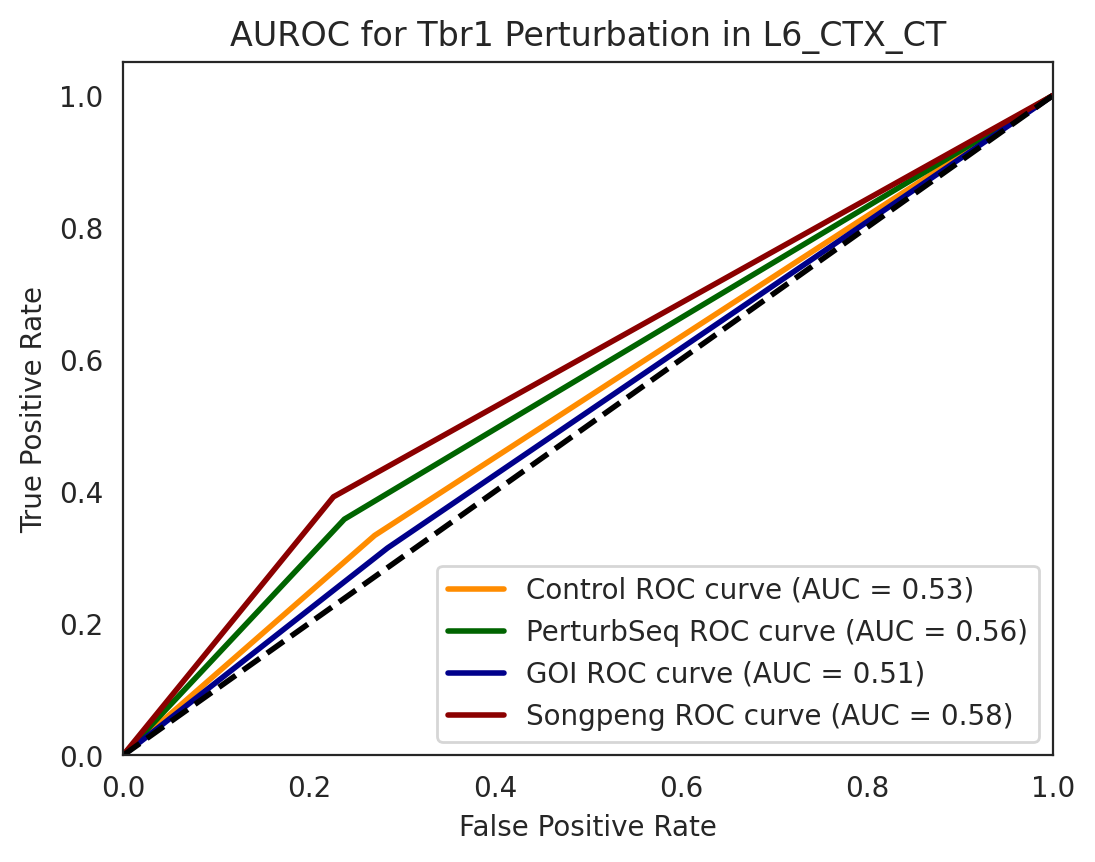

In [70]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example arrays (logFC for in silico and functional perturbations)
# Positive logFC classified as 1, negative as 0
ctrl_fc = [fc for fc in result['Control_Log2_Fold_Change']]  # LogFC from in silico perturbations
perturb_fc = result['PerturbSeq_Log2_Fold_Change']
goi_fc = result['Goi_Log2_Fold_Change']
songpeng_fc = merged_df['Treatment_Log2_Fold_Change']
functional_fc = result['logFC']  # LogFC from functional perturbations
songpeng_functional_fc = merged_df['logFC']  # LogFC from functional perturbations

# Convert logFC to binary classifications (1 = positive, 0 = negative)

ctrl_class = [1 if fc > 0 else 0 for fc in ctrl_fc]
perturb_class = [1 if fc > 0 else 0 for fc in perturb_fc]
goi_class = [1 if fc > 0 else 0 for fc in goi_fc]
songpeng_class = [1 if fc > 0 else 0 for fc in songpeng_fc]
functional_class = [1 if fc > 0 else 0 for fc in functional_fc]
songpeng_functional_class = [1 if fc > 0 else 0 for fc in songpeng_functional_fc]

# Create confusion matrix
ctrl_tn, ctrl_fp, ctrl_fn, ctrl_tp = confusion_matrix(functional_class, ctrl_class).ravel()
perturb_tn, perturb_fp, perturb_fn, perturb_tp = confusion_matrix(functional_class, perturb_class).ravel()
goi_tn, goi_fp, goi_fn, goi_tp = confusion_matrix(functional_class, goi_class).ravel()
songpeng_tn, songpeng_fp, songpeng_fn, songpeng_tp = confusion_matrix(songpeng_functional_class, songpeng_class).ravel()

# Calculate the ROC curve
ctrl_fpr, ctrl_tpr, ctrl_thresholds = roc_curve(ctrl_class, functional_class)
perturb_fpr, perturb_tpr, perturb_thresholds = roc_curve(perturb_class, functional_class)
goi_fpr, goi_tpr, goi_thresholds = roc_curve(goi_class, functional_class)
songpeng_fpr, songpeng_tpr, songpeng_thresholds = roc_curve(songpeng_class, songpeng_functional_class)


# Calculate the AUC
ctrl_roc_auc = auc(ctrl_fpr, ctrl_tpr)
perturb_roc_auc = auc(perturb_fpr, perturb_tpr)
goi_roc_auc = auc(goi_fpr, goi_tpr)
songpeng_roc_auc = auc(songpeng_fpr, songpeng_tpr)
print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(ctrl_fpr, ctrl_tpr, color='darkorange', lw=2, label=f'Control ROC curve (AUC = {ctrl_roc_auc:.2f})')
plt.plot(perturb_fpr, perturb_tpr, color='darkgreen', lw=2, label=f'PerturbSeq ROC curve (AUC = {perturb_roc_auc:.2f})')
plt.plot(goi_fpr, goi_tpr, color='darkblue', lw=2, label=f'GOI ROC curve (AUC = {goi_roc_auc:.2f})')
plt.plot(songpeng_fpr, songpeng_tpr, color='darkred', lw=2, label=f'Songpeng ROC curve (AUC = {songpeng_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Reference line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC for Tbr1 Perturbation in L6_CTX_CT')
plt.legend(loc="lower right")
plt.savefig("jinlab/ctrl_perturb_auroc.jpg")

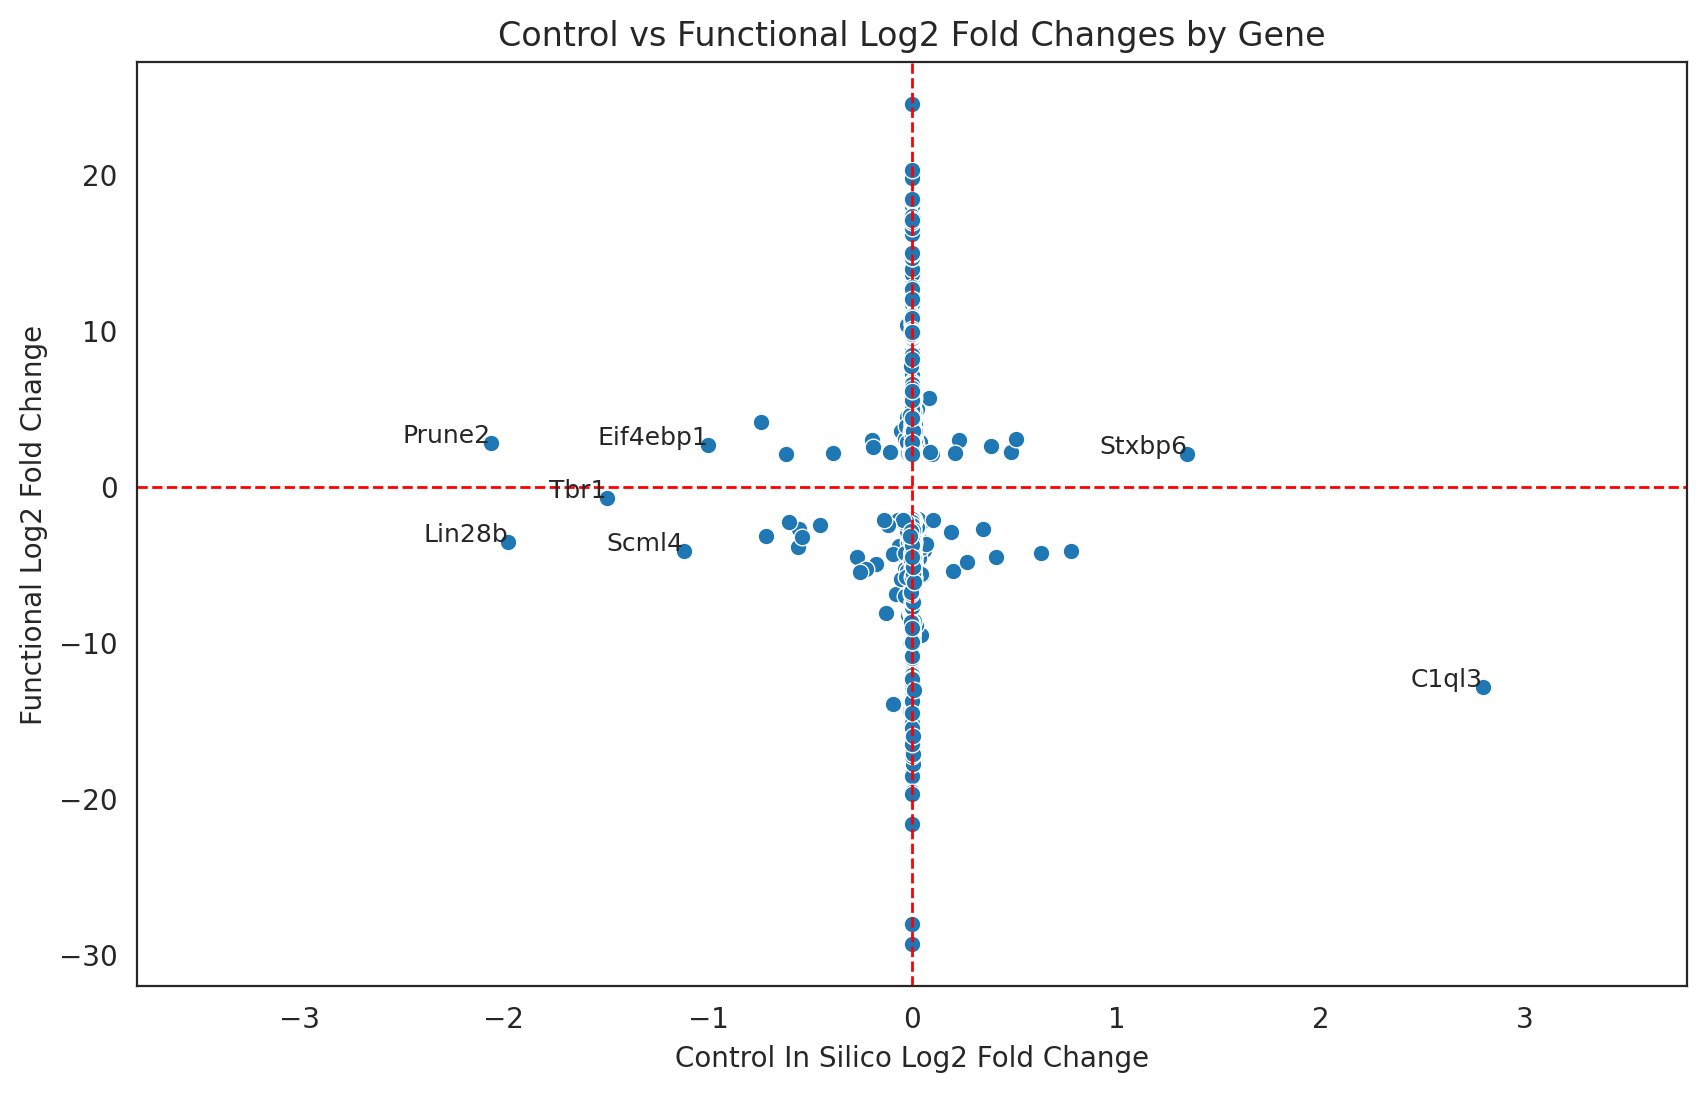

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result, x='Control_Log2_Fold_Change', y='logFC')


for i in range(0, len(result)):
    x_val = result['Control_Log2_Fold_Change'][i]
    y_val = result['logFC'][i]
    if abs(x_val) > 1:
        plt.text(
            x_val, 
            y_val, 
            result['Gene'][i],
            fontsize=9,
            ha='right'  # horizontal alignment
        )


max_x = max(abs(result['Control_Log2_Fold_Change'].min()), abs(result['Control_Log2_Fold_Change'].max()))
plt.xlim(-max_x-1, max_x+1) 

# Add labels and title
plt.xlabel('Control In Silico Log2 Fold Change')
plt.ylabel('Functional Log2 Fold Change')
plt.xticks()
plt.yticks()
plt.title('Control vs Functional Log2 Fold Changes by Gene')

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)


# Display the plot
plt.savefig("jinlab/DEG_ctrl_fnc_scatter.jpg")

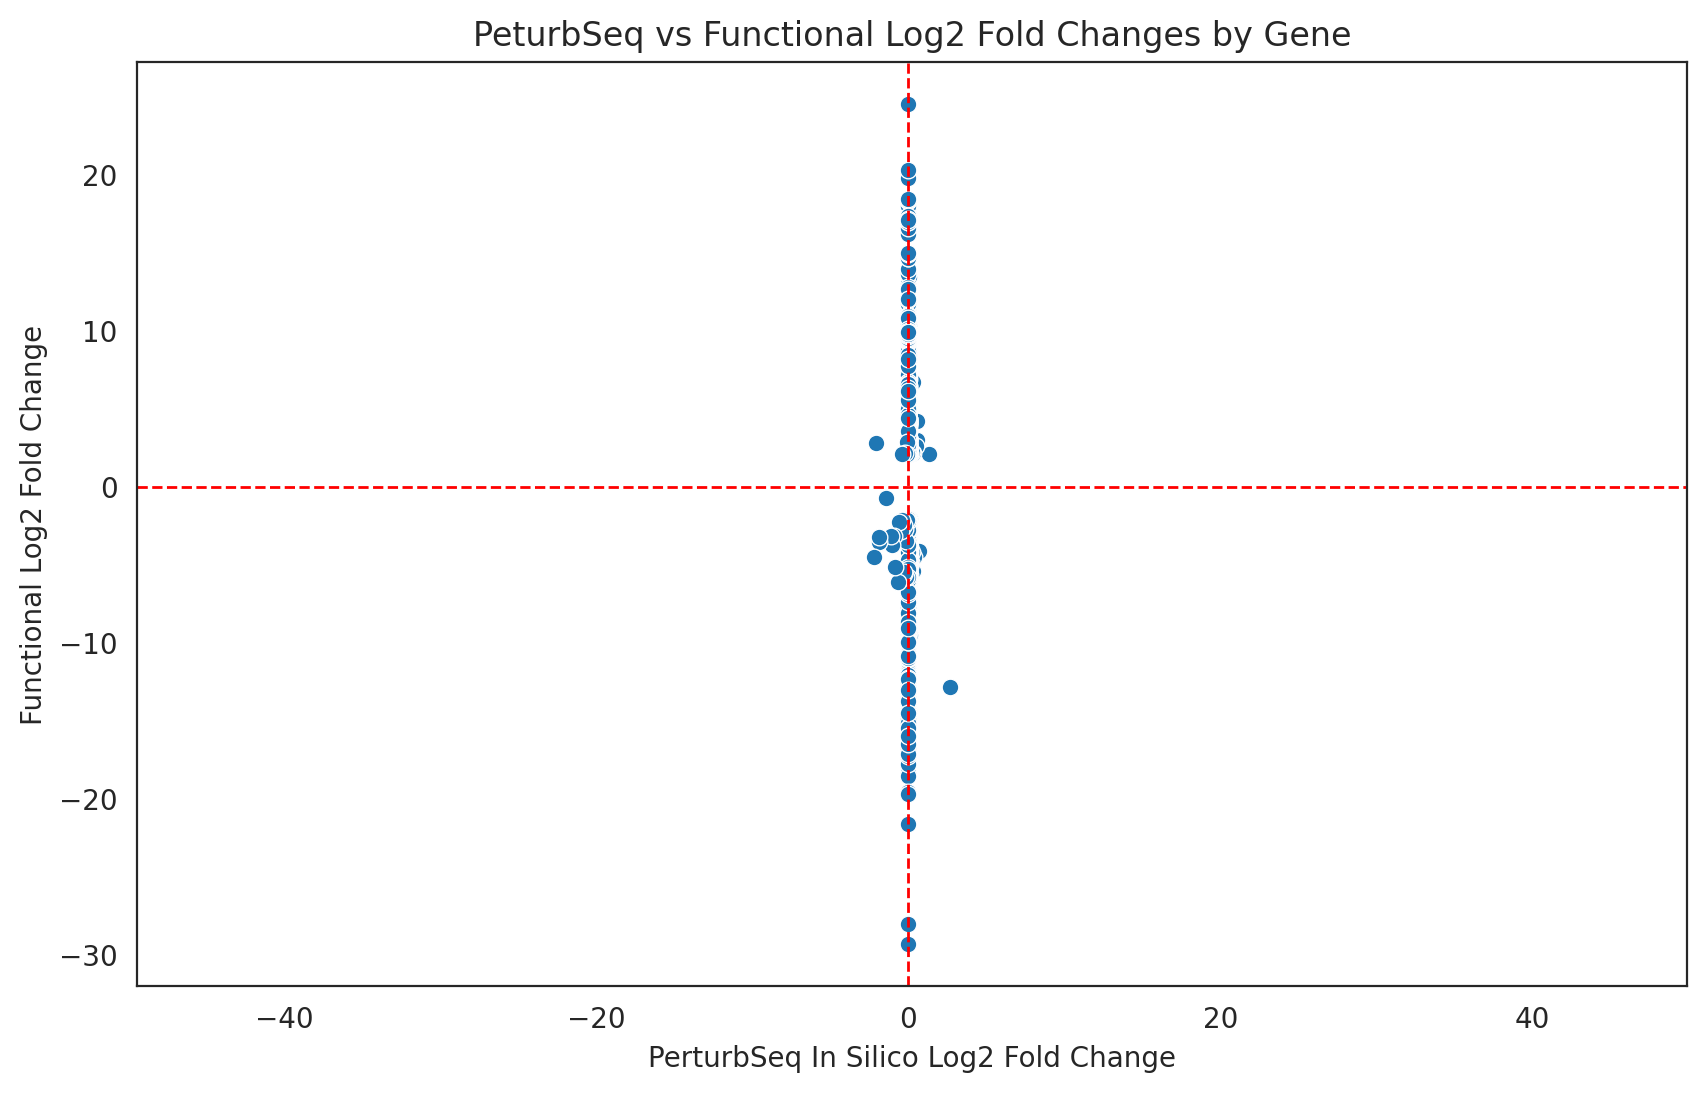

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result, x='PerturbSeq_Log2_Fold_Change', y='logFC')

"""
for i in range(1, len(result)):
    x_val = result['Control_Log2_Fold_Change'][i]
    y_val = result['logFC'][i]
    if abs(x_val) > 1 or abs(y_val) > 1:
        plt.text(
            x_val, 
            y_val, 
            result['Gene'][i],
            fontsize=9,
            ha='right'  # horizontal alignment
        )
"""

# Add labels and title
plt.xlabel('PerturbSeq In Silico Log2 Fold Change')
plt.ylabel('Functional Log2 Fold Change')
plt.xticks()
plt.yticks()
plt.title('PeturbSeq vs Functional Log2 Fold Changes by Gene')

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.axis('equal')


# Display the plot
plt.savefig("jinlab/DEG_perturb_fnc_scatter.jpg")

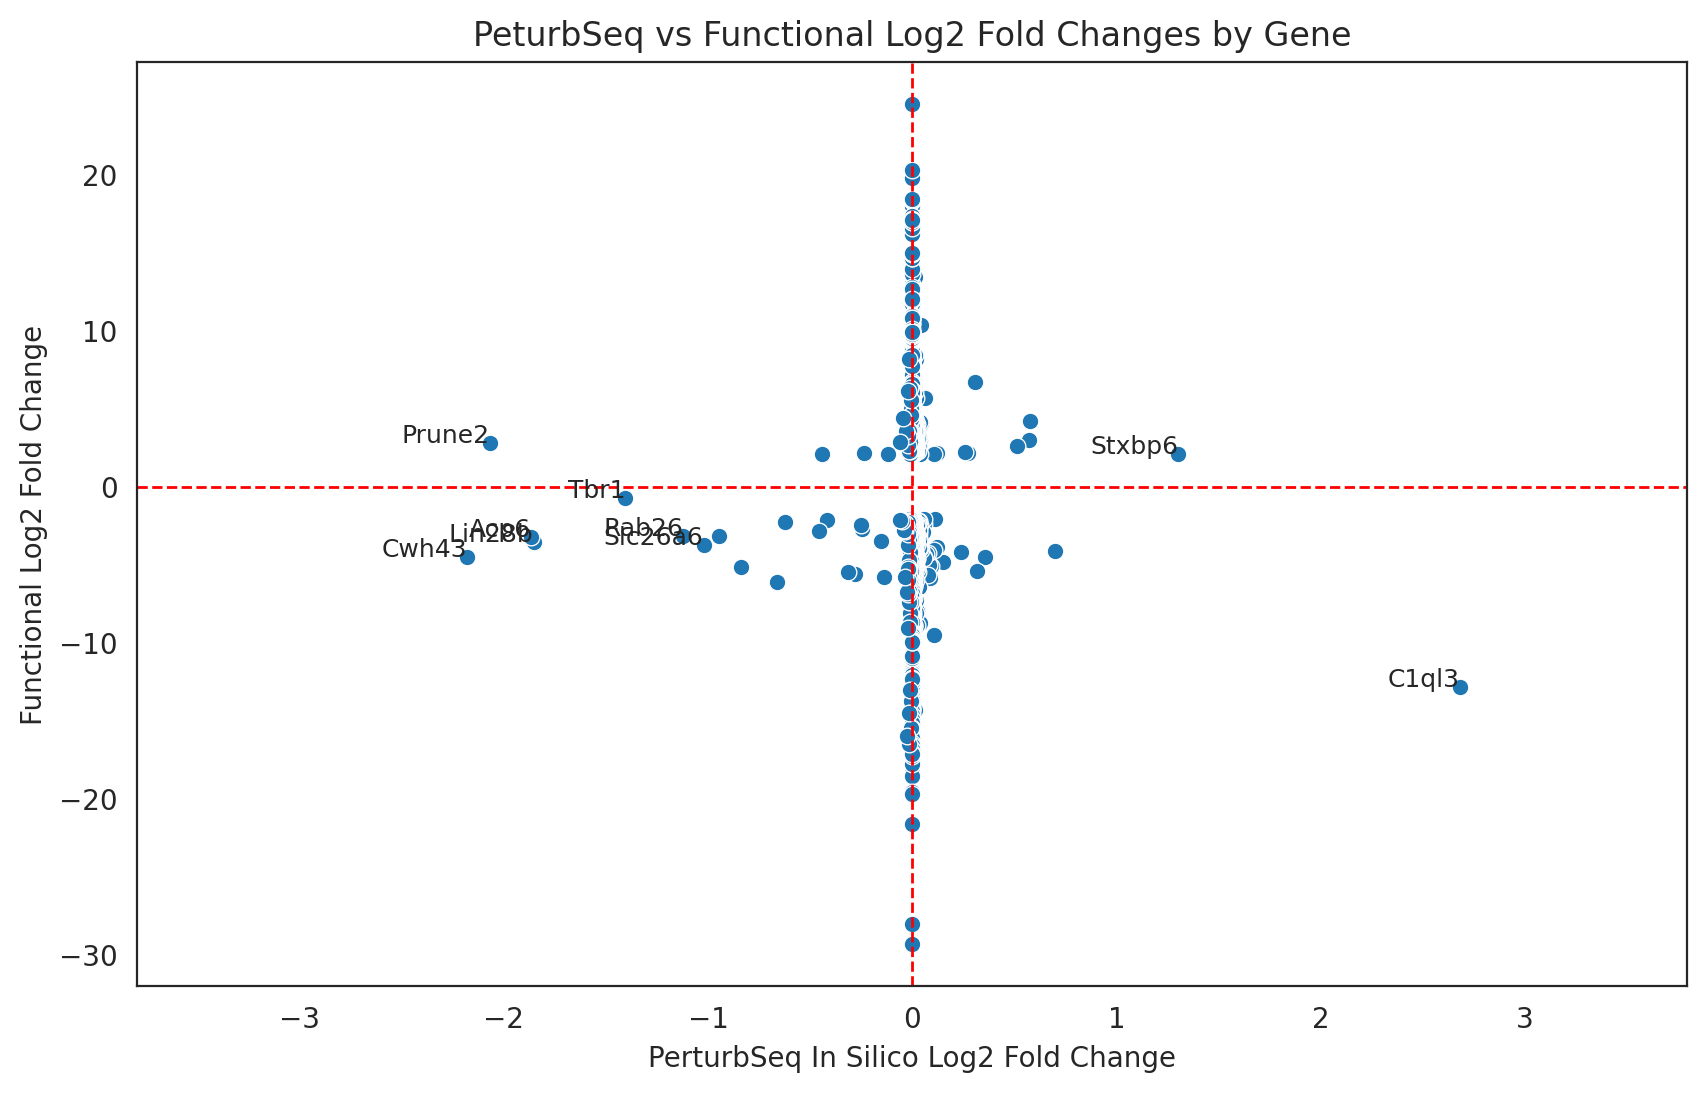

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result, x='PerturbSeq_Log2_Fold_Change', y='logFC')

for i in range(0, len(result)):
    x_val = result['PerturbSeq_Log2_Fold_Change'][i]
    y_val = result['logFC'][i]
    if abs(x_val) > 1:
        plt.text(
            x_val, 
            y_val, 
            result['Gene'][i],
            fontsize=9,
            ha='right'  # horizontal alignment
        )

# Add labels and title
plt.xlabel('PerturbSeq In Silico Log2 Fold Change')
plt.ylabel('Functional Log2 Fold Change')
plt.xticks()
plt.yticks()
plt.title('PeturbSeq vs Functional Log2 Fold Changes by Gene')

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

max_x = max(abs(result['Control_Log2_Fold_Change'].min()), abs(result['Control_Log2_Fold_Change'].max()))
plt.xlim(-max_x-1, max_x+1) 

# Display the plot
plt.savefig("jinlab/DEG_perturb_fnc_scatter.jpg")

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=result, x='Control_Log2_Fold_Change', y='logFC')


for i in range(0, len(result)):
    x_val = result['Control_Log2_Fold_Change'][i]
    y_val = result['logFC'][i]
    if abs(x_val) > 1:
        plt.text(
            x_val, 
            y_val, 
            result['Gene'][i],
            fontsize=9,
            ha='right'  # horizontal alignment
        )


max_x = max(abs(result['Control_Log2_Fold_Change'].min()), abs(result['Control_Log2_Fold_Change'].max()))
plt.xlim(-max_x-1, max_x+1) 

# Add labels and title
plt.xlabel('Control In Silico Log2 Fold Change')
plt.ylabel('Functional Log2 Fold Change')
plt.xticks()
plt.yticks()
plt.title('Control vs Functional Log2 Fold Changes by Gene')

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)


# Display the plot
plt.savefig("jinlab/DEG_ctrl_fnc_scatter.jpg")